<div style="text-align: right"> 
Universidad Nacional de Colombia <br>
Maestría en Ciencias - Estadística <br>
Big Data - Métodos Intensivos de Computación Estadística -2023829 <br>
Semestre 2021-1 
</div> 

<div style="text-align: right"> 
Estudiante: Diego Clemente Rojas Chingate   <br>
</div> 


# Dataset Reddit comments

Dataset de cada comentario público de Reddit disponible como un Torrent muy grande. [Fuente](https://github.com/dask/dask-tutorial/blob/main/Homework.ipynb)

Realizar lo siguiente:

1. [Usar "dask.bag" para inspeccionar los datos.](#1.-Usar-"dask.bag"-para-inspeccionar-los-datos.)

2. [Combinar "dask.bag" con "nltk" o "gensim" para realizar analisis textual en los datos.](#2.-Combinar-"dask.bag"-con-"nltk"-o-"gensim"-para-realizar-analisis-textual-en-los-datos.)

3. [Reproducir el trabajo de](#3.-Trabajo-de-Daniel-Rodriguez) [(Daniel Rodriguez)](https://web.archive.org/web/20201022041325/https://extrapolations.dev/blog/2015/07/reproduceit-reddit-word-count-dask/) [y ver si puede mejorar los tiempos de su analisis de datos](#3.-Trabajo-de-Daniel-Rodriguez)

# 1. Usar "dask.bag" para inspeccionar los datos.

### Obtener el Bag del archivo "RC_2015-01.bz2"

In [1]:
import dask.bag as db

bag_data = db.read_text("RC_2015-01")

### Primeras 5 líneas (cada línea es un objeto JSON)

In [2]:
bag_data.take(5)

('{"score_hidden":false,"name":"t1_cnas8zv","link_id":"t3_2qyr1a","body":"Most of us have some family members like this. *Most* of my family is like this. ","downs":0,"created_utc":"1420070400","score":14,"author":"YoungModern","distinguished":null,"id":"cnas8zv","archived":false,"parent_id":"t3_2qyr1a","subreddit":"exmormon","author_flair_css_class":null,"author_flair_text":null,"gilded":0,"retrieved_on":1425124282,"ups":14,"controversiality":0,"subreddit_id":"t5_2r0gj","edited":false}\n',
 '{"distinguished":null,"id":"cnas8zw","archived":false,"author":"RedCoatsForever","score":3,"created_utc":"1420070400","downs":0,"body":"But Mill\'s career was way better. Bentham is like, the Joseph Smith to Mill\'s Brigham Young.","link_id":"t3_2qv6c6","name":"t1_cnas8zw","score_hidden":false,"controversiality":0,"subreddit_id":"t5_2s4gt","edited":false,"retrieved_on":1425124282,"ups":3,"author_flair_css_class":"on","gilded":0,"author_flair_text":"Ontario","subreddit":"CanadaPolitics","parent_id"

### Mejorar la visualización de cada JSON en vez de mostrarlo como una línea 

In [3]:
import json
bag_data_json = bag_data.map(json.loads)

### Primera línea como objeto JSON

In [4]:
bag_data_json.take(5)

({'score_hidden': False,
  'name': 't1_cnas8zv',
  'link_id': 't3_2qyr1a',
  'body': 'Most of us have some family members like this. *Most* of my family is like this. ',
  'downs': 0,
  'created_utc': '1420070400',
  'score': 14,
  'author': 'YoungModern',
  'distinguished': None,
  'id': 'cnas8zv',
  'archived': False,
  'parent_id': 't3_2qyr1a',
  'subreddit': 'exmormon',
  'author_flair_css_class': None,
  'author_flair_text': None,
  'gilded': 0,
  'retrieved_on': 1425124282,
  'ups': 14,
  'controversiality': 0,
  'subreddit_id': 't5_2r0gj',
  'edited': False},
 {'distinguished': None,
  'id': 'cnas8zw',
  'archived': False,
  'author': 'RedCoatsForever',
  'score': 3,
  'created_utc': '1420070400',
  'downs': 0,
  'body': "But Mill's career was way better. Bentham is like, the Joseph Smith to Mill's Brigham Young.",
  'link_id': 't3_2qv6c6',
  'name': 't1_cnas8zw',
  'score_hidden': False,
  'controversiality': 0,
  'subreddit_id': 't5_2s4gt',
  'edited': False,
  'retrieved_on':

### ¿Cuántos comentarios Reddit hay en el dataset?

In [5]:
bag_data_json.count().compute()

5000

### ¿Cuántos comentarios controversiales hay?

In [6]:
bag_data_json.filter(lambda record: record['controversiality'] != 0).count().compute()

0

### ¿Cuántos comentarios han sido editados?

In [7]:
bag_data_json.filter(lambda record: record['edited'] == True).count().compute()

0

### ¿Cuántos comentarios han sido archivados?

In [8]:
bag_data_json.filter(lambda record: record['edited'] == True).count().compute()

0

### Top 10 de los usuarios con más comentarios

In [9]:
from operator import add
def incr(tot, _):
    return tot + 1

bag_data_json.foldby(key='author', 
                   binop=incr, 
                   initial=0, 
                   combine=add, 
                   combine_initial=0).map(lambda x: (x[1], x[0])).topk(10).compute()


[(403, '[deleted]'),
 (24, 'AutoModerator'),
 (13, 'XoXFaby'),
 (12, 'sharktopuskracken'),
 (6, 'subredditreports'),
 (6, 'loqi0238'),
 (6, 'king_kalamari'),
 (5, 'wasd-gamer'),
 (5, 'slicked9778'),
 (5, 'adalab')]

## 2. Combinar "dask.bag" con "nltk" o "gensim" para realizar analisis textual en los datos

### Remover Stopwords para hacer nube de palabras

In [10]:
import nltk
import gensim

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'im', 'want', 'like', 'x', 'x'*2, 'x'*3, 'x'*4, 'x'*5, 'x'*6, 'x'*7, 'x'*8, 'x'*9, 'x'*10, 'dont', 'ill', 'doesnt',"ive", 'wouldnt', 'theyll', 'didnt', "hes", "wasnt", "hell", "theres", "isnt", "theyre"])
stop_words.extend(list(gensim.parsing.preprocessing.STOPWORDS))
stop_words = list(set(stop_words))


### Nube de palabras

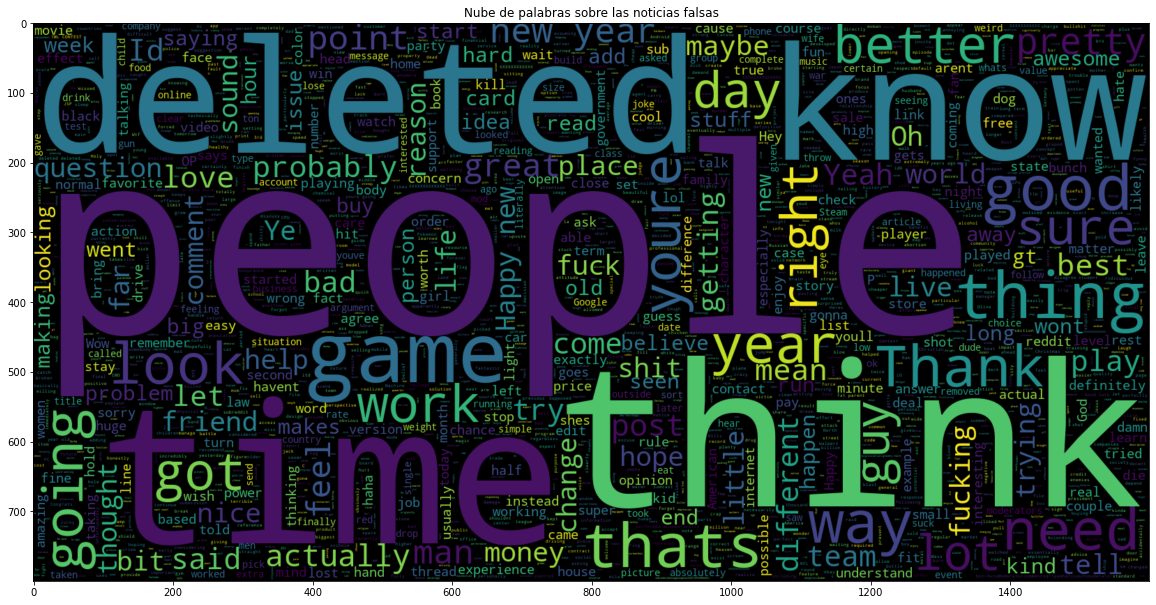

In [13]:
import matplotlib.pyplot as plt
import re

from wordcloud import WordCloud, STOPWORDS
plt.figure(figsize = (20,20)) 
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800 , stopwords = stop_words).generate(" ".join(bag_data_json
         .pluck('body') 
         .map(lambda x: re.sub("[^0-9a-zA-Z ]", "", x.strip()))
         .filter(lambda x: type(x) == str)
         .compute()))
plt.imshow(wc, interpolation = 'bilinear')
plt.title('Nube de palabras sobre las noticias falsas')
plt.show()

## 3. Trabajo de Daniel Rodriguez 

In [16]:
import re
import json
import time
import nltk
import dask
import dask.bag as db
import nltk
from nltk.corpus import stopwords

In [17]:
dask.__version__

'2021.07.0'

In [18]:
nltk.__version__

'3.6.2'

In [22]:
data = db.read_text("RC_2015-01_test", blocksize='10MB').map(json.loads)
data.take(1)

({'score_hidden': False,
  'name': 't1_cnas8zv',
  'link_id': 't3_2qyr1a',
  'body': 'Most of us have some family members like this. *Most* of my family is like this. ',
  'downs': 0,
  'created_utc': '1420070400',
  'score': 14,
  'author': 'YoungModern',
  'distinguished': None,
  'id': 'cnas8zv',
  'archived': False,
  'parent_id': 't3_2qyr1a',
  'subreddit': 'exmormon',
  'author_flair_css_class': None,
  'author_flair_text': None,
  'gilded': 0,
  'retrieved_on': 1425124282,
  'ups': 14,
  'controversiality': 0,
  'subreddit_id': 't5_2r0gj',
  'edited': False},)

In [23]:
no_stopwords = lambda x: x not in stopwords.words('english')

In [24]:
is_word = lambda x: re.search("^[0-9a-zA-Z]+$", x) is not None

In [43]:
subreddit = data.filter(lambda x: x['subreddit'] == 'movies')
bodies = subreddit.pluck('body')
words = bodies.map(nltk.word_tokenize).flatten()
words2 = words.filter(lambda x: type(x) == str).map(lambda x: x.lower()) 
words3 = words2.filter(no_stopwords)
words4 = words3.filter(is_word)
counts = words4.frequencies()

In [32]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/drojas/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [45]:
start_time = time.time()
values = counts.compute()
elapsed_time = time.time() - start_time

In [46]:
elapsed_time  # seconds

1.4320666790008545

In [47]:
len(values)

181

In [48]:
sort = sorted(values, key=lambda x: x[1], reverse=True)

In [49]:
sort[:100]

[('movies', 5),
 ('like', 4),
 ('movie', 4),
 ('one', 4),
 ('agree', 3),
 ('great', 3),
 ('thought', 3),
 ('unrealistic', 3),
 ('first', 2),
 ('time', 2),
 ('year', 2),
 ('big', 2),
 ('way', 2),
 ('well', 2),
 ('really', 2),
 ('little', 2),
 ('best', 2),
 ('years', 2),
 ('yes', 2),
 ('jar', 2),
 ('weird', 2),
 ('see', 2),
 ('goonies', 1),
 ('grosse', 1),
 ('pointe', 1),
 ('blank', 1),
 ('90', 1),
 ('mins', 1),
 ('expose', 1),
 ('spend', 1),
 ('much', 1),
 ('scene', 1),
 ('last', 1),
 ('30', 1),
 ('real', 1),
 ('quick', 1),
 ('end', 1),
 ('student', 1),
 ('picture', 1),
 ('vote', 1),
 ('coke', 1),
 ('panasonic', 1),
 ('ford', 1),
 ('paramount', 1),
 ('jurassic', 1),
 ('world', 1),
 ('looks', 1),
 ('heaping', 1),
 ('pile', 1),
 ('triceratops', 1),
 ('shit', 1),
 ('love', 1),
 ('man', 1),
 ('haha', 1),
 ('respect', 1),
 ('putting', 1),
 ('choice', 1),
 ('2009', 1),
 ('watch', 1),
 ('multiple', 1),
 ('times', 1),
 ('always', 1),
 ('sign', 1),
 ('dawn', 1),
 ('apes', 1),
 ('incredible', 1),

In [50]:
with open('r_movies.txt', 'w') as f:
    for item in sort:
        f.write("%s %i\n" % item)